## <h1><center><b>Project 5: Reinforcement Learning</b></center></h1>

<center><img src="https://www.cs.cornell.edu/courses/cs4782/2025sp/images/p5_rl_header.jpeg"></center>

In this project, we will explore fundamental reinforcement learning algorithms: Q-Learning, Deep Q-Networks (DQNs), and Policy Gradient Methods. We will implement these algorithms to train agents to play classic control environments from the OpenAI Gym library.

&nbsp;

---

**DO's:**

1.   **Running on GPU should not be necessary for this assignment.** You should be able to use the *free* Colab **T4 GPU** runtime to make your training faster, but most cells should take under 5 minutes, even on CPU.
2.   As before, all functionality you need to modify is within `submission.py`.
3.   Remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.
4.   Please cite any external sources you use to complete this assignment in your written responses.
5.   Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).

&nbsp;

**DONT's:**


1.   DO NOT change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with grading.
2.   DO NOT delete any provided code/imports.

&nbsp;

---

***NOTE:***
    
*You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Ed discussion board to engage with your peers or seek assistance from the TAs.*




# Part 0: Install Dependencies, Set up Colab


In [ ]:
# core
import os
import sys
import random
from itertools import count

# gym and rendering
import numpy as np
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as ImageWidget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mount your Google Drive; this allows the runtime environment to see/edit your submission code.
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# NOTE: Make sure your path does NOT include a '/' at the end!
base_dir = "/content/gdrive/MyDrive/PATH-TO-ASSIGNMENT-5-DIRECTORY"
sys.path.append(base_dir)

# This makes sure the submission module is reloaded whenever you make edits.
%load_ext autoreload
%aimport submission
%autoreload 1
import submission

## Taxi Game


In this part, you will train the agent to play a simple Taxi game using Q-learning.

<center><img src="https://www.gymlibrary.dev/_images/taxi.gif"></center>

There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

There are 6 discrete deterministic actions:

$\mathcal{A}=\left\{\begin{align}
&0, \text{ move south}\notag\\
&1, \text{ move north}\notag\\
&2, \text{ move east}\notag\\
&3, \text{ move west}\notag\\
&4, \text{ pick up passenger}\notag\\
&5, \text{ drop off passenger}\notag\\
\end{align}\right.$

There are $500$ discrete states since there are $25$ taxi positions, $5$ possible locations of the passenger (including the case when the passenger is in the taxi), and $4$ destination locations.

You can read the [full documentation](https://www.gymlibrary.dev/environments/toy_text/taxi/) for this environment set up.


Throughout this assignment, we will ask you to generate .gifs to showcase the policies you train.

In [ ]:
def save_frames_as_video(frames, filename="output", fps=10):
    """Saves a list of frames as individual images and a GIF animation."""
    if not ".gif" in filename:
        filename += ".gif"
    
    pil_images = []
    for frame in frames:
        img_array = np.array(frame)
        pil_img = Image.fromarray(img_array)
        pil_images.append(pil_img)

    pil_images[0].save(
        filename,
        save_all=True,
        append_images=pil_images[1:],
        duration=int(1000 / fps),
        loop=0
    )

    print(f"Saved {len(frames)} individual frames to {filename}")

## Taxi Visualization

We will begin by visualizing a random policy for the taxi environment. Update the `video_path` as needed. All generated gifs should be uploaded along with notebook.


In [ ]:
env = gym.make('Taxi-v3', render_mode = 'rgb_array')

frames = []
state, _ = env.reset(seed=random.randint(0,500))
frames.append(env.render())

for i in range(100):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    frames.append(env.render())
    if done: break

save_frames_as_video(frames, gifname:=f"{base_dir}/taxi_random.gif", fps=10)

env.close()

ImageWidget(gifname)

# Part 1: Tabular Q-Learning (20 pts)


## Q-Learning Background

Imagine you're playing a game where each move $a$ (action) you make in a specific situation $s$ (state) gives you a certain immediate reward $r(s,a)$ and also may bring you to a new future state $s'$. If you want to play optimally, you need an "oracle" to evaluate how your decision now impacts the sequence of your future rewards. Then you could just listen to the oracle, picking the action which maximizes your future rewards at every state.

We call this oracle $Q^\bigstar(s, a)$. It measures the expected long-term return if you pick action $a$ in state $s$ and then continue making optimal decisions afterward. If you had access to this "perfect knowledge," your policy $\pi$ is straightforward:

$$\pi^\bigstar(s) = \underset{a}{\text{argmax}}\left[Q^\bigstar(s, a)\right]$$

In other words, each turn simply choose the action that maximizes your expected future rewards.

In reality, you don't know everything about the environment you're in, so $Q^\bigstar$ is inaccessible. The key insight behind Q-learning is that even without full knowledge of the world, you can still learn good estimates of these optimal Q-values with *experience*.

### How to Q-Learn

Tabular Q-learning uses a massive table to represent the Q-function: $\mathbb{R}^{\text{States}\times \text{Actions}}$. The table can be initialized with random or zero estimates, but each entry will be the estimate for how good each action is in each state. Every time you take an action and observe what happens, you can update your estimates in the table and gradually get closer to the true $Q^\star$ values.

We can make such an update because Q-learning leverages an important relationship known as the **Bellman Equation**, which says that the value of a state-action pair $(s,a)$ under a policy $\pi$ can be expressed as:

$$Q^\pi(s, a) = r + \gamma Q^\pi(s', \pi(s'))$$

This means that the value of taking action $a$ in state $s$ under some policy $\pi$ equals the immediate reward $r$ plus a discounted estimate of future returns (the Q-value of the next state-action pair).

Because your estimates are initially imperfect, you’ll see discrepancies between your current estimate and the reality you observe. This difference is called the **Temporal Difference (TD) error** $\delta$, and it's the core signal which we can use to drive Q-learning updates:

$$\delta = \underset{\text{new target estimate}}{\underbrace{\left(r + \gamma \max_{a'} Q(s', a')\right)}}\ - \underset{\text{current estimate}}{\underbrace{Q(s, a)}}$$

* If $\delta$ is positive, your action was worse than expected—*you should increase the Q-value*.
* If $\delta$ is negative, your action was better than expected—*you should decrease the Q-value*.

Take time to justify this to yourself.

### The Q-learning Update Rule

This intuition leads to the main update rule in Q-learning. Given an experience tuple $(s,a,r,s')$, we make the following update:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left(\underset{\text{temporal difference error},\ \delta}{\underbrace{r + \gamma \max_{a'} Q(s', a') - Q(s, a)}}\right)$$

Rearranging, we can get to the following update rule:

$$Q(s, a) \leftarrow (1-\alpha)Q(s, a) + \alpha \left(r + \gamma \max_{a'} Q(s', a')\right)$$

Where:
* $\alpha$ is the learning rate
* $\gamma$ is the discount factor

### Convergence and Optimality

Over many experiences, this simple rule ensures your Q-values become increasingly accurate approximations of $Q^\bigstar$. Once your Q-values stabilize (or "converge"), you have essentially found the optimal Q-function:

$$Q(s,a)\approx Q^\bigstar(s,a), \forall s,a$$

While this *does* imply $\underset{a}{\max} Q(s,a) \approx \underset{a}{\max} Q^\bigstar(s,a)$, do note that we cannot guarantee that $\underset{a}{\text{argmax}}\ Q(s,a) = \underset{a}{\text{argmax}}\ Q^\bigstar(s,a)$.

Arbitrarily small errors in the Q-function may cause $\text{argmax}$ to pick an action which is ever-so-slightly preferred over the true optimal. So our max-policy $\pi(s):=\underset{a}{\text{argmax}}\ Q(s,a)$ could still be quite different from $\pi^\bigstar$. Fortunately, this scenario corresponds to multiple actions being equally valid (within some tolerance), and so we still expect $\pi$ to perform quite well.

## Q-Learning Algorithm
We present the Q-learning algorithm as follows:

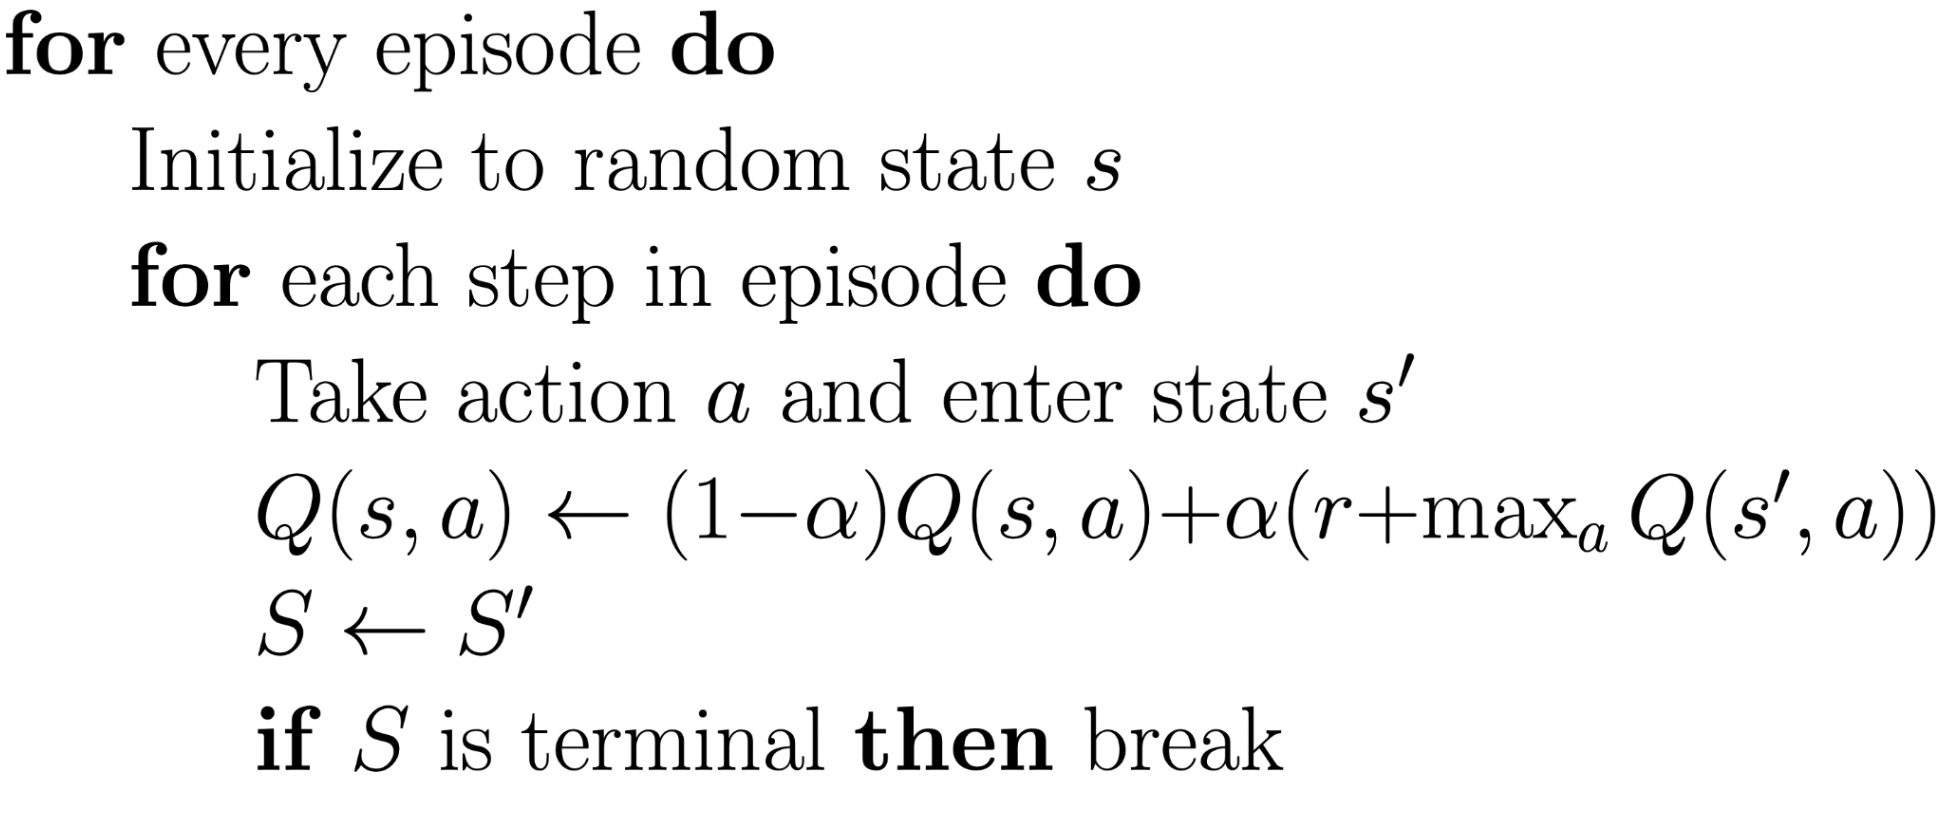


### **TODO 1:** Implement `sample_action` in `submission.py`.

When selecting an action, we'll employ the $\epsilon$-greedy strategy. With a probability of $1 - \epsilon$, the agent will choose the action that maximizes the Q-value for the current state based on the Q-table. With a probability of $\epsilon$, the agent will explore by selecting a random action.

* You can obtain a random action using the following code:
    ```python
        a = env.action_space.sample()
    ```

* To get the optimal action from the Q-table, you'll need to find the action that corresponds to the highest Q-value for the current state.

### **TODO 2:** Implement `q_update` in `submission.py`.

Use the equation in the algorithm provided above to update the Q table given some experience.

### **TODO 3:** Complete the `q_learning` method in `submission.py`.
*Make sure to utilize the methods you implemented in the first two TODOs.*

* To start an episode and obtain the initial state, you can use the following code:
    ```python
        observation, info = env.reset()
    ```
    * The `observation` variable will store the initial state of the environment.

* To execute the chosen action and observe the outcome, you can use the following code:
    ```python
        s_next, r, terminated, truncated, info = env.step(a)
    ```
    * `s_next`: The state that the agent transitions to after taking action `a`.
    * `r`: The reward associated with taking action `a` in the current state.
    * `terminated`: A boolean value indicating whether the agent has reached a terminal state.
    * `truncated`: A boolean value indicating whether the episode has been truncated due to conditions outside the scope of the Markov Decision Process (MDP), such as exceeding a time limit.

* Make sure to update `rewards_per_episode` to keep track of the rewards obtained over the course of each trajectory.

If you need further information, you can refer to the following documentation:

- `env.reset()`: [https://gymnasium.farama.org/api/env/#gymnasium.Env.reset](https://gymnasium.farama.org/api/env/#gymnasium.Env.reset)
- `env.step()`: [https://gymnasium.farama.org/api/env/#gymnasium.Env.step](https://gymnasium.farama.org/api/env/#gymnasium.Env.step)
- `env.action_space.sample()`: [https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.sample](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.sample)

In [ ]:
from submission import q_learning

In [ ]:
# default prameters for Q-learning
alpha = .6
gamma = .9
epsilon = 0.05
epis = 1000

# initialize the environment
observation, info = env.reset()

# initialize the Q table
Q = np.zeros([env.observation_space.n, env.action_space.n])

# run Q-learning
Q, rewards_per_episode = q_learning(Q, env, epsilon, alpha, gamma, epis)
print("Final Q table\n", Q)

In [ ]:
# Plot the rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rewards_per_episode) + 1), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()

## Tabular Q-Learning Visualization

Let's now visualize the learned policy for the taxi environment. Update the `video_path` as needed. All generated gifs should be uploaded along with notebook.


In [ ]:
env = gym.make('Taxi-v3', render_mode = 'rgb_array')

frames = []
state, _ = env.reset(seed=random.randint(0,500))
frames.append(env.render())

for i in range(100):
    action = np.argmax(Q[state,:])
    state, reward, done, _, _ = env.step(action)
    frames.append(env.render())
    if done: break

save_frames_as_video(frames, gifname:=F"{base_dir}/taxi_q_learning.gif", fps=5)

env.close()

ImageWidget(gifname)

### **Q1**: How does the behavior of the Q-Learning agent compare to the random policy visualized previously? What policy does the agent appear to have learned? (5pts)

Write 2-3 sentences in your responses document (.tex available on Canvas) which will be submitted alongside your assignment. 


# Part 2: Deep Q-Networks (40 pts)


Deep Q-Networks (DQNs) extend the concept of Q-learning by using neural networks to approximate the Q-function, enabling it to handle large or continuous state spaces. Instead of maintaining a table of Q-values, a DQN learns a parameterized Q-function $Q(s, a; \theta) \approx Q^\star(s, a)$, where $\theta$ represents the weights of the neural network.

The training process involves minimizing the temporal difference error between the predicted Q-value and the target Q-value, calculated using the Bellman equation. Note that this equation introduces a $\theta^-$, which represents the parameters of a separate target network (often a recent version of $\theta$). We update $\theta^-$ periodically to stabilize training.

\begin{align}
\underset{\text{target}}{\underbrace{Q^\pi(s, a)}} = \underset{\textit{true }\text{reward plus future }\textit{estimate}}{\underbrace{r + \gamma \max_{a'} Q^\pi(s', a'; \theta^-)}}
\end{align}

The loss function for training the DQN is just the mean squared error between the target network and our current network:

\begin{align}
\mathcal{L}(\theta)
&= \underset{(s, a, r, s') \sim \mathscr{D}_\text{rb}}{\mathbb{\Large E}}\left[\left(Q^\pi(s, a) - Q(s, a; \theta)\right)^2\right]\\
&= \underset{(s, a, r, s') \sim \mathscr{D}_\text{rb}}{\mathbb{\Large E}}\left[\left(r + \gamma \max_{a'}Q(s', a'; \theta^-) - Q(s, a; \theta)\right)^2\right]
\end{align}

Where $\mathscr{D}_\text{rb}$ is the replay buffer storing the agent's experience tuples.

By minimizing this loss function using gradient descent, the DQN approximates the optimal Q-function, which can be used to derive our policy $\pi(s) = \underset{a}{\text{argmax}}\ Q(s, a; \theta)$.

In the following sections, we will explore the implementation details of DQNs and their application to complex reinforcement learning tasks.


## Cart Pole


You will be implementing the deep q-network to train the agent to play a slightly harder game, Cart Pole. In this game, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

Before you implement your deep Q-network, read this [documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to see what are the actions and states in this game.

<center><img src="https://gymnasium.farama.org/_images/cart_pole.gif"></center>

## Cartpole Visualization

We will begin by visualizing a random policy for the cartpole environment. Update the `video_path` as needed. All generated gifs should be uploaded along with notebook.


In [ ]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

frames = []
done=False
state, _ = env.reset(seed=random.randint(0,500))
frames.append(env.render())

while not done:
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    frames.append(env.render())

save_frames_as_video(frames, gifname:=f"{base_dir}/cartpole_random.gif", fps=20)

env.close()

ImageWidget(gifname)

## 2.1: DQN Network (10 pts)


### **TODO 4:** In the constructor (`__init__`), the network should be initialized with the following layers:

1. An input linear layer (`self.layer1`) that maps the state observations to 128 hidden units.
2. A hidden linear layer (`self.layer2`) with 128 input units and 128 output units.
3. An output linear layer (`self.layer3`) that maps the 128 hidden units to the number of actions.


### **TODO 5:** In the `forward` method, the network should perform the following operations:

***NOTE:** When implementing ReLUs <u>use the functional interface</u> for this assignment. We have already imported torch.nn.functional as `F`, so be sure to call `F.relu()` whenever you need a ReLU in the forward pass instead of using defining `nn.ReLU()` layers in the init.*

1. Pass the input `x` through the first linear layer (`self.layer1`) followed by a ReLU activation function.
2. Pass the result through the second linear layer (`self.layer2`) followed by another ReLU activation function.
3. Pass the result through the output linear layer (`self.layer3`).
4. Return the final output.

**Implement the `DQN` class in `submission.py`** and then import it below:



In [ ]:
from submission import DQN

## Transition and Experience Replay


Here we provide you the Transition class, which stores a transition from the current state to the next state by taking action a with the associated reward r. The ReplayMemory stores all the transitions that the action has experienced, aka memory. Read the code and comment and make sure you are understand the attributes and methods. You will need to use some of them.


In [ ]:
# Do not modify
class Transition(object):
  def __init__(self, s, a, next_s, r):
    self.state = s
    self.action = a
    self.next_state = next_s
    self.reward = r


class ExperienceReplay(object):
    def __init__(self, capacity):

        # Capacity of the agent's memory, always an int
        self.cap = capacity
        # A list of Transition objects that represent the agent's experiences
        self.memory = []
        # Current position of the agent, 0 <= self.pos < len(self.memory)
        self.pos = 0


    def push(self, *args):
        """
        Push a transition to the agent's memory.
        """
        if len(self.memory) < self.cap:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.cap


    def sample(self, batch_size):
        """
        Uniformly random sample batch_size of Transitions
        """
        return random.sample(self.memory, batch_size)


    def __len__(self):
        return len(self.memory)

## 2.2: DQN Agent (20 pts)


Now you will implement the DQNAgent in `submission.py`. This DQNAgent class should store two neural networks, as mentioned in lecture:

- a policy network that predicts the next action
- a target network that predicts the target Q-value

### **TODO 6**: Implement the epsilon-greedy strategy with the `eps_threshold` in `select_action`
- We will use a decayed $ϵ$-strategy this time. In particular, we use this formula to calculate the current $ϵ$ value:
$$ϵ = ϵ_\text{end} + (ϵ_\text{start} - ϵ_\text{end})⋅\exp(-\frac{\text{# steps done}}{ϵ_\text{decay}})$$
- If `sample` is greater than `eps_threshold`, choose the action with the highest Q-value according to the policy network (exploitation).
  - Use the policy network to get the Q-values for the current state.
  - Find the index of the action with the highest Q-value.
  - Wrap the result in a tensor with shape (1, 1).
- If `sample` is less than or equal to `eps_threshold`, choose a random action (exploration).
  - Generate a random action tensor with shape (1, 1) and the appropriate device and data type.
- When sampling an action, use `torch.no_grad` or an alternative way of disabling gradient computations --- we are simply gathering experiences, so we don't want to keep gradient information. Think of this just like the original tabular Q-learning algorithm; we don't need to know how we sampled an action, we just use the experience itself to update the Q-table.

### **TODO 7**: Compute the target state-action values using the Bellman equation

- The target state-action values are calculated as the sum of the immediate reward and the discounted maximum Q-value of the next state.
- Use the Bellman equation to compute the target state-action values:
  - $Q^\pi(s, a) = r + \gamma Q^\pi(s', \pi(s'))$
  - `next_state_values` contains the maximum Q-values of the next states (already computed) with shape (batch_size,).
  - `self.gamma` is the discount factor (scalar).
  - `reward_batch` contains the immediate rewards for each transition in the batch with shape (batch_size,).
- The resulting `expected_state_action_values` tensor should have shape (batch_size,).


***NOTE**: You should take time to read through the `get_values` method in DQNAgent to understand what it returns.*

### **TODO 8:** Compute the loss between the predicted state-action values and the target state-action values using the SmoothL1Loss

- Use the SmoothL1Loss criterion to compute the loss between the predicted state-action values (`state_action_values`) and the target state-action values (`expected_state_action_values`).
    - `self.criterion` is already defined in the `DQNAGent.__init__`, so use this to compute the loss. 
- `state_action_values` has shape (batch_size, 1), while `expected_state_action_values` has shape (batch_size,).
- Make sure that the dimensions of `expected_state_action_values` match `state_action_values` and that both are the shape you expect.
- Assign the computed loss to the `loss` variable.

**Implement `DQNAgent` class in `submission.py`** then import it below:


In [ ]:
from submission import DQNAgent

We provide the training loop for the DQN.


In [ ]:
def train_dqn(agent, env, num_episodes, render=False):
    episode_durations = []

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0

        for t in count():
            # Select action
            action = agent.select_action(state)

            # Perform the action and observe the next state and reward
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward.item()

            # Determine if the episode is done
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in the replay buffer
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization
            if len(agent.memory) >= agent.batch_size:
                agent.optimize_model()

            if done:
                episode_durations.append(t + 1)
                print(f"Episode {i_episode+1}/{num_episodes}, Reward: {episode_reward:.2f}, Duration: {t+1}")
                break

        # Update the target network
        if i_episode % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

    env.close()
    return episode_durations

## 2.3 Training and Visualization (10 pts)


In [ ]:
dqn_agent = DQNAgent(env, device)
train = train_dqn(dqn_agent, env, num_episodes=150, render=False)

In [ ]:
# Plot the rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train) + 1), train)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()

## Cartpole DQN Visualization

We visualize the DQN policy for the cartpole environment. Update the `video_path` as needed. All generated gifs should be uploaded along with notebook.


In [ ]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

frames = []
done=False
state, _ = env.reset(seed=random.randint(0,500))
frames.append(env.render())

while not done:
    torch_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = dqn_agent.select_action(torch_state).item()
    state, reward, done, _, _ = env.step(action)
    frames.append(env.render())

save_frames_as_video(frames, gifname:=f"{base_dir}/cartpole_dqn.gif", fps=20)

env.close()

ImageWidget(gifname)

### **Q2**: How does the behavior of the DQN agent compare to the random policy visualized previously? What policy does the DQN agent appear to have learned? (5 pts)

Answer with 2-3 sentences in your response document.


# Part 3: Policy Gradient (40 pts)


Now, we want to train the agent using the Reinforce algorithm to play the same game CartPole. Here is the algorithm we presented in lecture: 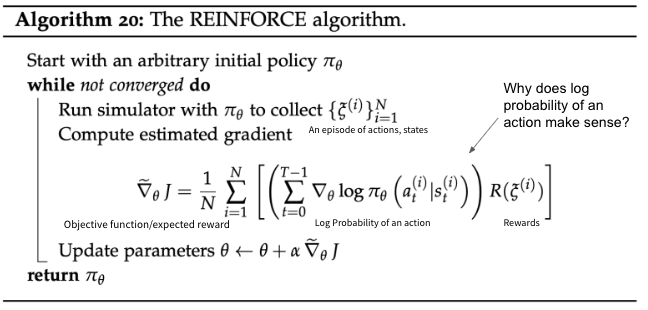


## 3.1 The Policy Network (10 pts)


Now you will implement a policy gradient method in `submission.py` by implementing `PolicyNetwork`.

### **TODO 9:** In the constructor (`__init__`), the network should be initialized with the following layers:

1. An input linear layer (`self.fc1`) that maps the observation features to 128 hidden units.
    - Apply `F.relu()` on the output of this layer before the next layer in the forward pass.
2. A hidden linear layer (`self.fc2`) that maps the 128 hidden units to the number of actions.
3. A Softmax activation function (`self.softmax`) for the output layer.


The constructor should take the following arguments:

- `number_observation_features` (int): The number of features in the observation space.
- `number_actions` (int): The number of possible actions.


### **TODO 10:** In the `forward` method, the network should take in an observation of the current state of the environment and output a distribution of scores per action.

1. Pass the input tensor `x` through the input linear layer (`self.fc1`).
    - You can assume that `x` is not batched and just has shape (observation_dim,)
2. Apply the ReLU activation function to the output of the input layer.
3. Pass the result through the hidden linear layer (`self.fc2`).
4. Apply the Softmax activation function to the output of the hidden layer.
5. Return the final output tensor with scores per action.


**Implement `PolicyNetwork` class in `submission.py`** then run below to import it:


In [ ]:
from submission import PolicyNetwork

## 3.2 The Reinforce Agent (15 pts)


Finish the implementation of the class ReinforceAgent in `submission.py`.

### **TODO 11:** The `choose_action` method of the agent should perform the following steps:
1. Process the current state through the policy model to get the action probabilities.
2. Create a categorical distribution with the action probabilities.
    - ***NOTE**: We have imported `Categorical` from `torch.distributions` for you.*
3. Sample an action from the distribution, representing the chosen action.
4. Compute the log probability of the sampled action, which is used for training the policy.





### **TODO 12:** The `calculate_reinforce_loss` method in the agent should:
1. Subtract the mean from the returns to obtain a quantity known as the advantage.
2. Multiply the negative log probabilities with the advantage to obtain the loss for each action.
3. Return the mean of the loss across actions.

### **TODO 13:** Implement the `calculate_discounted_returns` method.

As a reminder, the cumulative discounted return at timestep $i$ is given as:

\begin{equation*}
\sum_{t=i}^{T} \gamma^{t-i} R(s_t, a_t)
\end{equation*}
where:

- $\gamma \in [0, 1]$: Discount factor that balances immediate and future rewards.
- $R(s_t, a_t)$: Return obtained from the environment at time step $t$ for taking action $a_t$ in state $s_t$.

For numerical stability reasons, **and to please the autograder**, pay attention to the following as you implement this method:

* By definition, for each timestep $i$ the cumulative discounted returns sums up discounted returns from timestep $i$ to timestep $T$. This involves many repetitive calculations, when computed in increasing order of timesteps.
* Is there a way for you to reuse the repetitive calculations??
* Specifically, think of iterate over the episode rewards in *reverse order* and make use of the values you have already computed. 
* In the reverse order, you start with an undiscounted reward $(\gamma^{T-T}*reward = \gamma^0* reward)$
* An easy recursive/iterative way to evaluate the cumulative reward should emerge if you start by using this undiscounted reward.
* Make sure that the first timestep $(t=0)$ corresponds to the beginning of the list.

These discounted returns will be used in the training process to update the agent's policy network and encourage it to make decisions that maximize future cumulative discounted rewards.

**Implement `ReinforceAgent` class in `submission.py`** then import it below:


In [ ]:
from submission import ReinforceAgent, calculate_discounted_returns

## 3.3 Reinforce Training (5 pts)


Now let's train our Reinforce Agent.


In [ ]:
def train_reinforce(agent, env, num_steps=50, num_episodes_per_update=5, gamma=0.98):
    episode_durations = []

    for step in range(num_steps):
        batch_log_probability_actions = []
        batch_returns = []

        for _ in range(num_episodes_per_update):
            episode_log_probability_actions = []
            episode_rewards = []

            episode_reward = 0
            state, _ = env.reset()

            for t in count():
                s = torch.from_numpy(state)
                action, log_probability_action = agent.choose_action(s)

                next_state, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward

                episode_rewards.append(reward)
                episode_log_probability_actions.append(log_probability_action)

                done = terminated or truncated
                if done:
                    episode_durations.append(t + 1)
                    print(f"Step {step+1}/{num_steps}, Episode Reward: {episode_reward:.2f}, Duration: {t+1}")
                    break

                state = next_state

            discounted_returns = calculate_discounted_returns(episode_rewards, gamma)

            batch_log_probability_actions.append(episode_log_probability_actions)
            batch_returns.append(discounted_returns)

        batch_log_probability_actions = torch.cat([torch.stack(episode_log_probs) for episode_log_probs in batch_log_probability_actions])
        batch_returns = torch.tensor(sum(batch_returns, []), dtype=torch.float32)

        epoch_loss = agent.calculate_reinforce_loss(
            batch_log_probability_actions,
            batch_returns
        )

        epoch_loss.backward()
        agent.optimizer.step()
        agent.optimizer.zero_grad()

    env.close()
    return episode_durations

## 3.4 Reinforce Visualization (5 pts)


In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
reinforce_agent = ReinforceAgent(env)
train = train_reinforce(reinforce_agent, env, num_steps=300)

In [ ]:
plt.plot(train)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episode Durations')
plt.show()

In [ ]:
window_size = 20  # Adjust the window size as needed
smoothed_train = np.convolve(train, np.ones(window_size) / window_size, mode='valid')

# Plot the smoothed data
plt.plot(smoothed_train)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Smoothed Episode Durations')
plt.show()


## Cartpole Reinforce Visualization

We visualize the Reinforce policy for the cartpole environment. Update the `video_path` as needed. All generated gifs should be uploaded along with notebook.


Note that action selection with the Reinforce Agent is stochastic so different runs with the same agent will produce different results. You can re-run the code to observe different interactions with the environment.


In [ ]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

frames = []
done=False
state, _ = env.reset(seed=random.randint(0,500))
frames.append(env.render())

while not done:
    torch_state = torch.from_numpy(state)
    action = reinforce_agent.choose_action(torch_state)[0]
    state, reward, done, _, _ = env.step(action)
    frames.append(env.render())

save_frames_as_video(frames, gifname:=f"{base_dir}/cartpole_reinforce.gif", fps=20)

env.close()

ImageWidget(gifname)

### **Q3**: Compare your results for using DQN and Reinforce. Discuss the performance, convergence, and behavior of the two algorithms. Consider factors such as the stability of learning, the quality of the learned policies, and the behavior of the final policy. (5 pts)

Respond with 2-3 sentences in your responses document.


### **SUBMISSION INSTRUCTIONS**
Congratulations! Last coding assignment completed!

1.   Upload the `.py` or a `.zip` to **[Coding Assignment 5](https://www.gradescope.com/courses/963234/assignments/6120914/review_grades)**  containing `submission.py`.

2.   Upload a `.zip `with the written responses <u>*and all generated gifs*</u> to questions in the notebook to **[Coding Assignment 5 Responses](https://www.gradescope.com/courses/963234/assignments/6145269/)**. Your `.zip` should contain:

- `responses.tex/pdf/etc`
- `taxi_random.gif`
- `taxi_q_learning.gif`
- `cartpole_random.gif`
- `cartpole_dqn.gif`
- `cartpole_reinforce.gif`